## Qiskit ADAPT-VQE tutorial

### Define the molecule
We start by defining the molecule using ``pyscf``. As an example we select the LiH molecule and build it by providing its geometry.
This part of the code is based on ``Example_Molecules.ipynb`` jupyter notebook found at https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/.

### Generate the fermionic Hamiltonian
We generate the fermionic Hamiltonian consisting of creation and annihilation operators. Single-electron (h1e) and double-electron (h2e) operators are extracted below.

### Map the fermionic Hamiltonian to a qubit operator
Now, we map the fermionic Hamiltonian to a qubit Hamiltonian using the Jordan-Wigner transformation. Here, we implement the Jordan-Wigner mapper directly using only ``PySCF``, ``numpy``, and ``Qiskit``, as implemented in https://learning.quantum.ibm.com/course/quantum-chemistry-with-vqe/the-hamiltonian.

In [1]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.units import DistanceUnit


driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.59",
    basis="sto3g",
    unit=DistanceUnit.ANGSTROM,   
)

# Full problem
full_problem = driver.run()
print(full_problem.num_particles)
print(full_problem.num_spatial_orbitals)
print(full_problem.hamiltonian.constants)

as_transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_spatial_orbitals=5,
    active_orbitals=[1, 2, 3, 4, 5],
)

as_problem = as_transformer.transform(full_problem)
print(as_problem.num_particles)
print(as_problem.num_spatial_orbitals)
print(as_problem.hamiltonian.constants)

mapper = JordanWignerMapper()
fermionic_op = as_problem.hamiltonian.second_q_op()
qubit_op = mapper.map(fermionic_op)

H = qubit_op

print(len(H))


/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


(2, 2)
6
{'nuclear_repulsion_energy': 0.998447567773585}
(1, 1)
5
{'nuclear_repulsion_energy': 0.998447567773585, 'ActiveSpaceTransformer': -7.800375958281276}
276


In [2]:
from qiskit_algorithms import NumPyMinimumEigensolver

exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(H)
exact_eigval = exact_result.eigenvalue
print(f"Exact minimum eigenvalue: {exact_eigval}")

H_constants = list(as_problem.hamiltonian.constants.values())
H_shift = sum(H_constants)
print(f"Exact electronic ground state: {exact_eigval + H_shift}")


Exact minimum eigenvalue: -1.0803168169635198
Exact electronic ground state: -7.882245207471211


### Outline of the ADAPT-VQE algorithm
This algorithm was first introduced in https://arxiv.org/abs/1812.1117.

1. Initiate the quantum computer in the Hartree-Fock state. In Jordan-Wigner transformation, this has a bitstring representation implemented with $X$-gates.

2. Define the pool of operators as the set of excitation operators generated by the UCC ansatz. Note that under the Jordan-Wigner transformation, these operators are anti-Hermitian. 

3. Define the following conditions for termination: CONVERGED, MAXIMUM.
    - CONVERGED: Gradient of all operators from the pool are smaller than some threshold.
    - MAXIMUM: Maximum number of iterations reached.
    
4. while not TERMINATE (CONVERGED or MAXIMUM):
    - Compute the gradient of each operator from the pool and select the operator with the maximum gradient
    - Append the ansatz with $\textrm{exp}(j*\theta_i*\textrm{operator}_i)$
    - Run VQE over all parameters $\theta_i$

### Initial state
A common strategy is to initiate the quantum computer to the Hartree-Fock state, which we do with the help of the function below.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


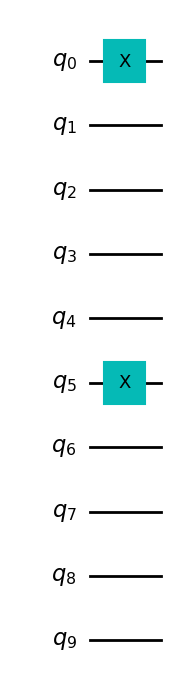

In [3]:
from qiskit_nature.second_q.circuit.library import HartreeFock

num_spatial_orbitals = as_problem.num_spatial_orbitals
num_particles = as_problem.num_particles

hf_circuit = HartreeFock(num_spatial_orbitals, num_particles, mapper)
hf_circuit.draw(output='mpl')

In [4]:
from qiskit.primitives import Estimator

estimator = Estimator(options={"shots": None, "approximation": True})
hf_energy = estimator.run(hf_circuit, qubit_op).result().values[0]
print(f"Hartree-Fock energy: {hf_energy} is {hf_energy - exact_eigval} above the exact ground state.")

Hartree-Fock energy: -1.0602464292560696 is 0.020070387707450177 above the exact ground state.


### Operator pool
We define the set of operators as the single and double excitation operators generated by the UCC ansatz. These operators are also represented under the Jordan-Wigner transform. Note that this results in anti-Hermitian excitation operators, but we omit the complex phase 1j for simplicity. Therefore, they appear Hermitian.

In [5]:
from qiskit_nature.second_q.circuit.library.ansatzes import UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper

qubit_mapper = JordanWignerMapper()

# Define the pool of operators as the single and double excitation operators generated by the UCC ansatz
ucc = UCC(num_spatial_orbitals, num_particles, 'sd', qubit_mapper)
excitation_pool =  ucc.operators  # TODO
print(f"The excitation pool consists of {len(excitation_pool)} operators.")

The excitation pool consists of 24 operators.


### Gradient of the excitation operators
We compute the gradient of all excitation operators in the pool given the current optimized ansatz. 

In [6]:
def compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=None):
    """
    Computes the gradients for all available excitation operators.
    Args:
        ansatz: ansatz built so far.
        hamiltonian: Hamiltonian after qubit mapping in SparsePauliOp format.
        excitation_pool: anti-Hermitian operators whose gradients need to be computed.
        estimator: an instance of the Qiskit Estimator primitive
        params: parameters to be assigned to the ansatz, if any.
    Returns:
        List of computed gradients in the same order as the excitation operators in the excitation pool.
    """
    # The excitations operators are applied later as exp(i*theta*excitation).
    # For this commutator, we need to explicitly pull in the imaginary phase.
    if params is not None:
        ansatz_opt = ansatz.assign_parameters(params)
    else:
        ansatz_opt = ansatz
    # We recall that 1j was omitted earlier for the anti-Hermitian operators.
    commutators = [1j * (hamiltonian @ exc - exc @ hamiltonian) for exc in excitation_pool]
    ansatz_list = [ansatz_opt for _ in range(len(commutators))]
    gradients = estimator.run(ansatz_list, commutators).result().values

    return gradients

Let's grow the ansatz step by step by before putting the code into a loop. First, our ansatz is simply the Hartree-Fock initial state. Now we will compute the gradient of each operator in the excitation pool and select the operator with the largest gradient to append to our current ansatz with a corresponding variational parameter. For now, we use an exact simulator by defining the options of the Qiskit Estimator primitive.

In [7]:
import numpy as np
from qiskit.primitives import Estimator

ansatz = hf_circuit
hamiltonian = H
estimator = Estimator(options={"shots": None, "approximation": True})

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))
max_operator = excitation_pool[max_index]
print(f"Found operator {max_operator} with maximum gradient {max_gradient} at index {max_index}.")

[ 2.36926453e-08  0.00000000e+00  0.00000000e+00  1.35356602e-09
  2.36926453e-08  0.00000000e+00  0.00000000e+00  1.35356606e-09
 -2.59287260e-02  0.00000000e+00  0.00000000e+00  6.89637005e-02
  0.00000000e+00 -4.69553018e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -4.69553018e-02  0.00000000e+00
  6.89637005e-02  0.00000000e+00  0.00000000e+00 -2.47637434e-01]
Found operator SparsePauliOp(['YZZZYXZZZY', 'XZZZYYZZZY', 'XZZZXXZZZY', 'YZZZXYZZZY', 'XZZZYXZZZX', 'YZZZYYZZZX', 'YZZZXXZZZX', 'XZZZXYZZZX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j]) with maximum gradient 0.24763743394926327 at index 23.


### Expand the Ansatz
We found that a double-excitation operator in the pool has the largest gradient magnitude. Therefore, we will now append it to the ansatz as $\textrm{exp}(i*\theta_0*\textrm{max\_operator})$, where $\theta_0$ is the corresponding time evolution parameter. This will be our variational parameter to be optimized in the VQE step. Now we can easily time-evolve the selected operator by using the ``EvolvedOperatorAnsatz`` from Qiskit. Note that the operator to be complex exponentiated and evolved consists of summed Pauli operators. Therefore, the evolution parameter of this ansatz class can be specified to run with different methods such as ``LieTrotter``, ``SuzukiTrotter``, or exactly with ``MatrixExponential`` to test small problems.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


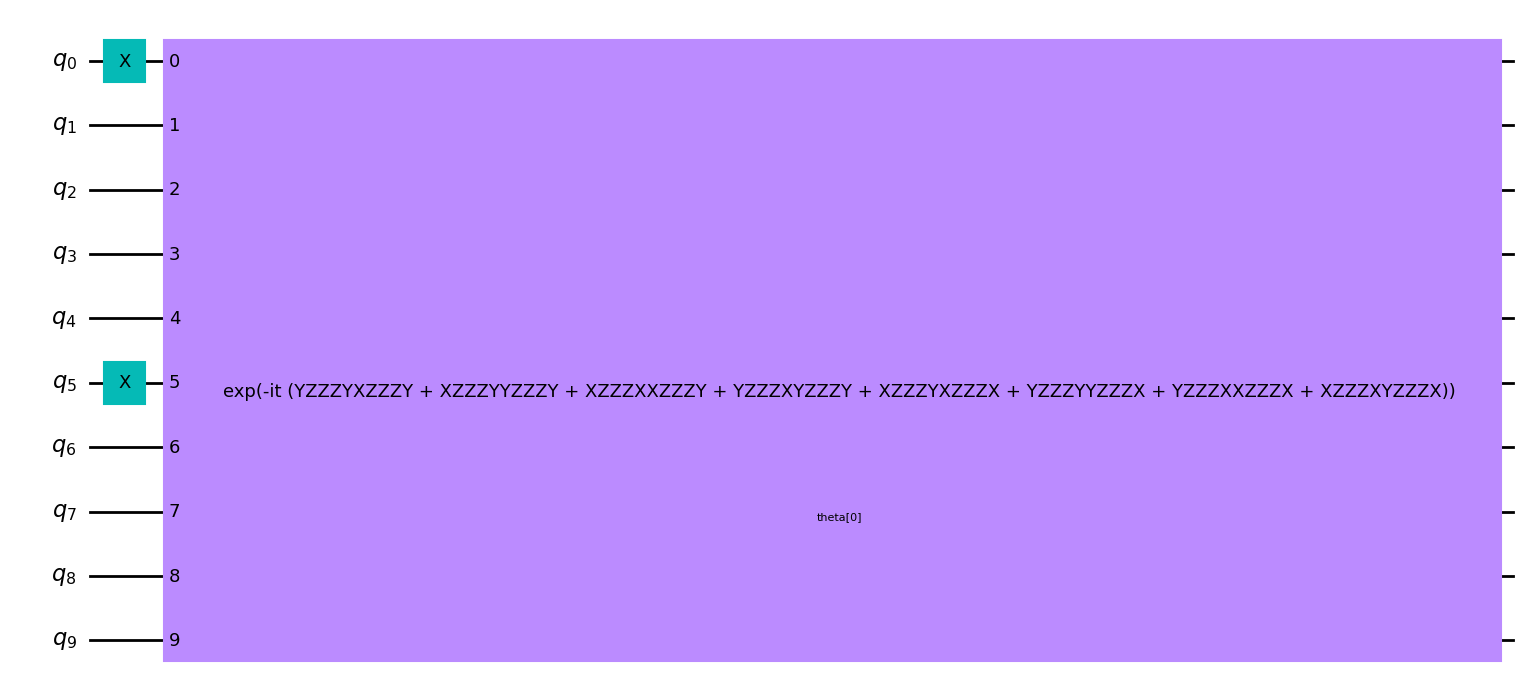

In [8]:
from qiskit.circuit.library import EvolvedOperatorAnsatz
from qiskit.synthesis import LieTrotter, MatrixExponential

ansatz = EvolvedOperatorAnsatz(operators=max_operator, evolution=MatrixExponential(), parameter_prefix='theta', initial_state=hf_circuit)
ansatz.decompose().draw(output = 'mpl')

Note that adding an operator to the ansatz does not drain the pool, i.e. the operator we added can again be selected in another iteration.

### Run VQE
We are now ready to run a full VQE on the ansatz that we have so far. We define the cost function as the expectation of the Hamiltonian as usual, and set up the Estimator primitive and randomly initiate the parameters to be optimized.

In [9]:
def cost_func(params, ansatz, H, estimator):
    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
    return energy

In [10]:
from qiskit.primitives import Estimator

estimator = Estimator(options={"shots": None, "approximation": True})

In [11]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(x0)

[1.95711264]


Now we classically optimize the $\theta_0$ parameter of our ansatz using the ``minimize`` function from ``scipy``.

In [12]:
from scipy.optimize import minimize

res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
print(res)


# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun') + H_shift
print(f"Found ground energy: {ground_energy}, exact energy: {exact_eigval + H_shift}, difference: {ground_energy - exact_eigval - H_shift}")

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0747029445589993
       x: [ 3.025e+00]
    nfev: 22
   maxcv: 0.0

Found ground energy: -7.8766313350666906, exact energy: -7.882245207471211, difference: 0.005613872404520492
   Normal return from subroutine COBYLA

   NFVALS =   22   F =-1.074703E+00    MAXCV = 0.000000E+00
   X = 3.025272E+00


In [13]:
# Optimal parameters so far
x_opt =  getattr(res, 'x')
print(x_opt)

[3.02527201]


### Another iteration of the algorithm
We now compute the gradients again to see if we need another iteration.

In [14]:
gradient_threshold = 1e-3

gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params=x_opt)
print(gradients)

max_gradient = np.max(np.abs(gradients))
max_index = np.argmax(np.abs(gradients))

print(f"Found maximum gradient {max_gradient} at index {max_index}")
print(f"Maximum gradient is below the threshold: {max_gradient < gradient_threshold}")

[ 0.00733397  0.          0.         -0.00194146  0.00733397  0.
  0.         -0.00194146 -0.01948708  0.          0.          0.07359587
  0.         -0.04178004  0.          0.          0.          0.
 -0.04178004  0.          0.07359587  0.          0.          0.00019631]
Found maximum gradient 0.07359586585830459 at index 11
Maximum gradient is below the threshold: False


Since the maximum gradient is not below the threshold, we append the operator at the found index to the ansatz.

/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


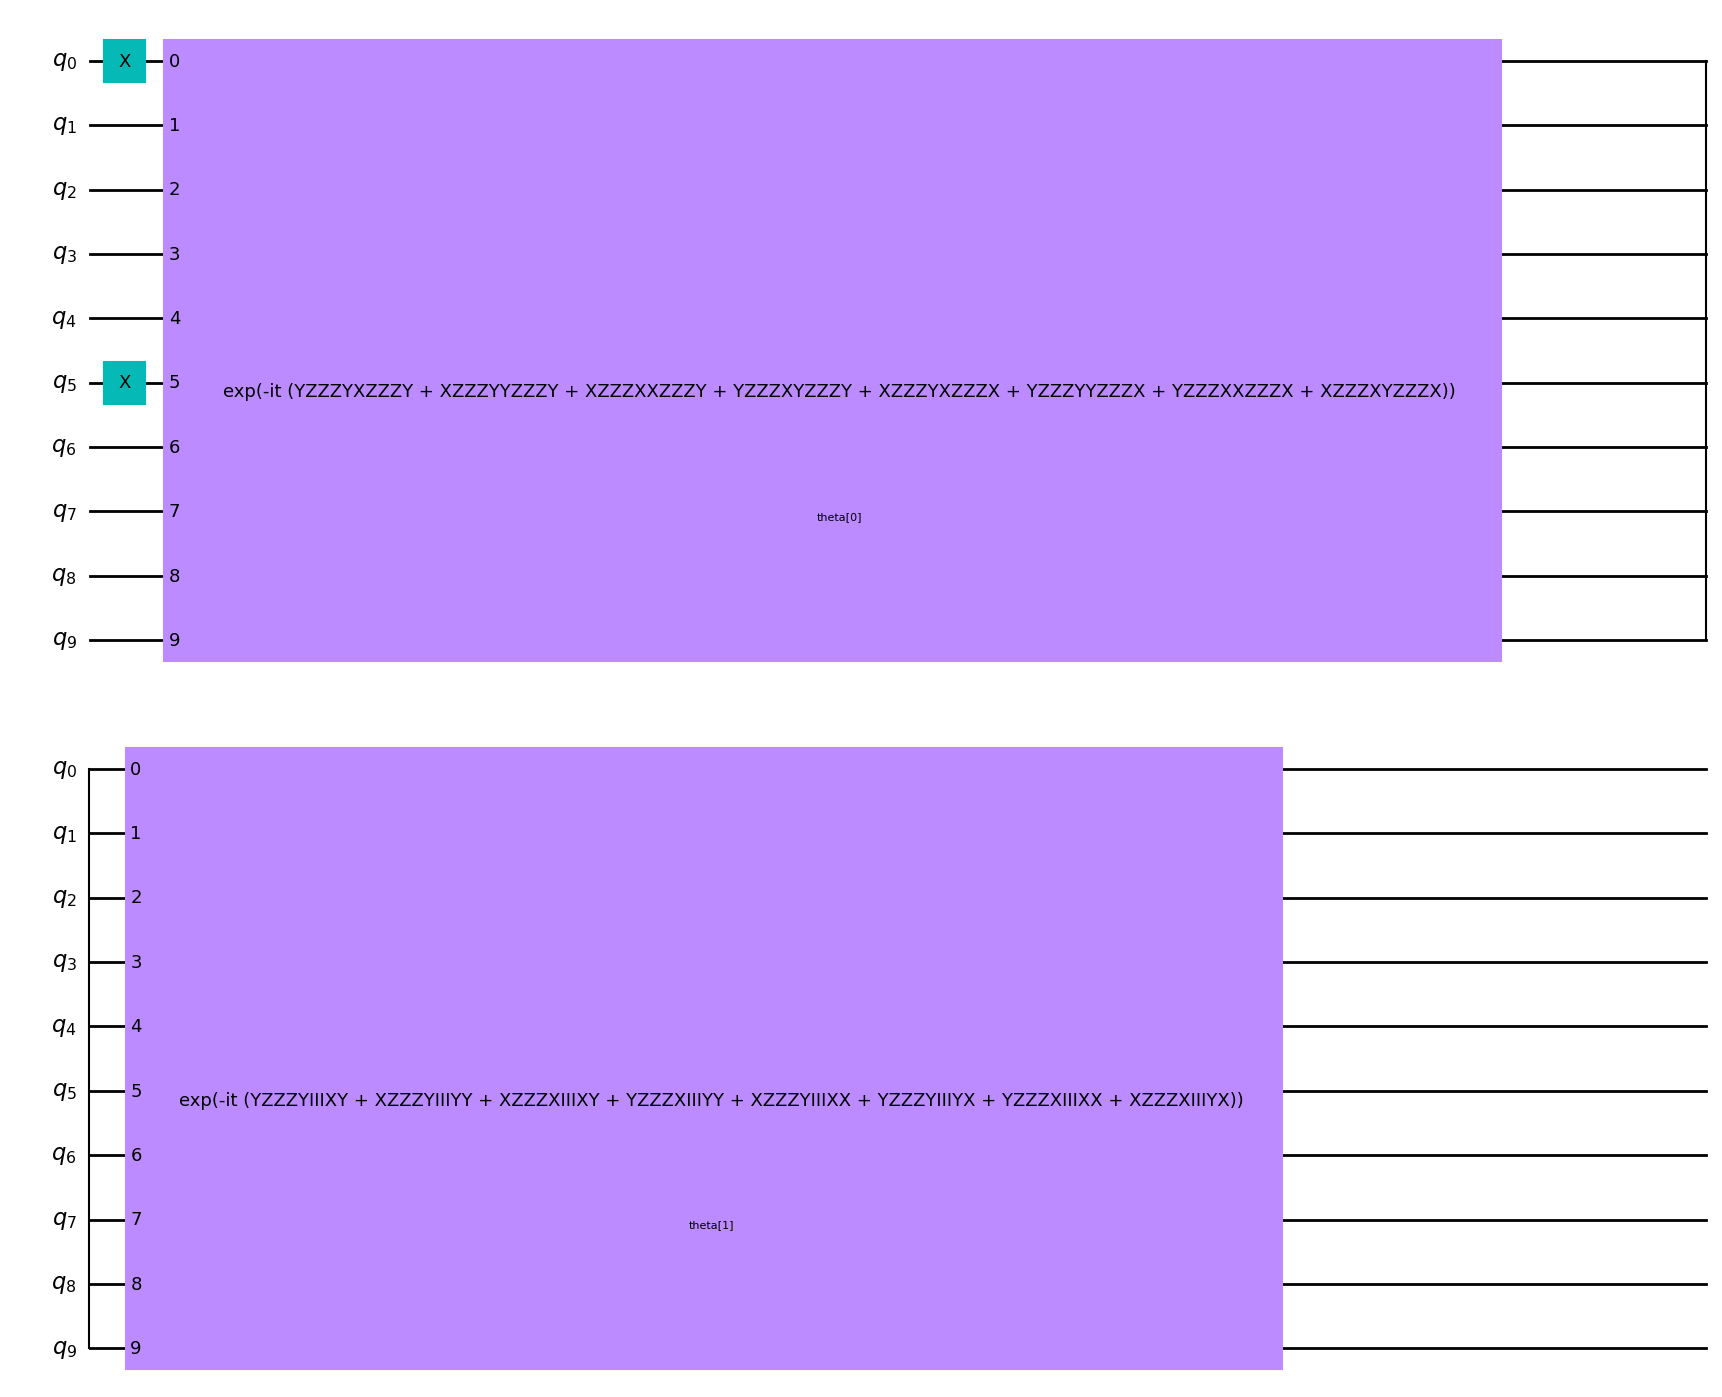

In [15]:
# Initiate the list of operators with the first one 
operator_list = [max_operator]
# Append the second operator
operator_list.append(excitation_pool[max_index])

ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit) 
ansatz.decompose().draw(output = 'mpl')

In [16]:
# Random start for the ansatz parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(x0)

res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="cobyla", options={'maxiter': 50, 'disp': True})
print(res)

# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun') + H_shift
print(f"Found ground energy: {ground_energy}, exact energy: {exact_eigval + H_shift}, difference: {ground_energy - exact_eigval - H_shift}")

[4.59221157 2.42849133]
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0765906858023189
       x: [ 6.400e+00  3.193e+00]
    nfev: 40
   maxcv: 0.0
   Normal return from subroutine COBYLA

   NFVALS =   40   F =-1.076591E+00    MAXCV = 0.000000E+00
   X = 6.400254E+00   3.192785E+00

Found ground energy: -7.87851907631001, exact energy: -7.882245207471211, difference: 0.0037261311612013515


### Putting it all together
Now we automate the algorithm in a single loop.

In [17]:
# Define the conditions for termination
gradient_threshold = 1e-3
max_iter = 15
terminate = False

# Initiate the problem
ansatz = hf_circuit
hamiltonian = H
excitation_pool = ucc.operators  # TODO
estimator = Estimator(options={"shots": None, "approximation": True})
params = None

iter = 0
operator_list = []
while not terminate:
    print(f"Iter: {iter}")
    gradients = compute_gradients(ansatz, hamiltonian, excitation_pool, estimator, params)
    max_gradient = np.max(np.abs(gradients))
    print(f"Maximum gradient: {max_gradient}")
    # Check convergence
    if max_gradient > gradient_threshold:
        # Find the operator with the largest gradient
        max_index = np.argmax(np.abs(gradients))
        max_operator = excitation_pool[max_index]
        print(f"Operator: {max_operator} at index {max_index}")
        # Grow the ansatz
        operator_list.append(max_operator)
        ansatz = EvolvedOperatorAnsatz(operators=operator_list, evolution=LieTrotter(), parameter_prefix='theta', initial_state=hf_circuit) 
        # Run VQE on the current ansatz
        x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz, H, estimator), method="slsqp", options={'maxiter': 50, 'disp': True})
        print(f"Result at iter {iter}: {getattr(res, 'fun') + H_shift}")
        x_opt =  getattr(res, 'x')
        params = x_opt
        # Terminate if maximum number of iterations reached
        iter += 1
        if iter >= max_iter:
            print("Terminating: reached maximum iteration.")
            terminate = True
    # Terminate if converged
    else:
        print("Terminating: converged.")
        terminate = True
    
# Note this returns the total energy, and we are often interested in the electronic energy
ground_energy = getattr(res, 'fun') + H_shift
print(f"Found ground energy: {ground_energy}, exact energy: {exact_eigval + H_shift}, difference: {ground_energy - exact_eigval - H_shift}")

Iter: 0
Maximum gradient: 0.24763743394926327
Operator: SparsePauliOp(['YZZZYXZZZY', 'XZZZYYZZZY', 'XZZZXXZZZY', 'YZZZXYZZZY', 'XZZZYXZZZX', 'YZZZYYZZZX', 'YZZZXXZZZX', 'XZZZXYZZZX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j]) at index 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0747029530371732
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 7
Result at iter 0: -7.876631343544864
Iter: 1
Maximum gradient: 0.07359237164321655
Operator: SparsePauliOp(['IIIYYXZZZY', 'IIIXYYZZZY', 'IIIXXXZZZY', 'IIIYXYZZZY', 'IIIXYXZZZX', 'IIIYYYZZZX', 'IIIYXXZZZX', 'IIIXXYZZZX'],
              coeffs=[-0.125+0.j, -0.125+0.j, -0.125+0.j,  0.125+0.j, -0.125+0.j,  0.125+0.j,
  0.125+0.j,  0.125+0.j]) at index 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0765906918345165
            